# Auto Encoders
Author: Soham Vaishnav\
Roll No.: 2022112002

## Importing libraries

In [1]:
import numpy as np
from plotly import express as px
from plotly import subplots as sp
from plotly import graph_objects as go
from matplotlib import pyplot as plt
import pandas as pd
import sys
import os
import wandb

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import torchvision.transforms as transforms

## Setting up paths

In [2]:

AssignDIR = os.path.dirname(os.path.dirname(os.path.abspath('AutoEncoder.ipynb')))
CurrDIR = os.path.dirname(os.path.abspath('AutoEncoder.ipynb'))
UserDIR = os.path.dirname(AssignDIR)

sys.path.append(UserDIR)

RawDataDIR = os.path.join(UserDIR, "./data/external/")
PreProcessDIR = os.path.join(UserDIR, "./data/interim/4/")

from utils_4 import *
from models.AutoEncoders import auto_encoder, cnn_autoencoder, pca_autoencoder

## Dataloading

In [4]:
loader = FashionMNISTLoader(batch_size=64)

train_loader, val_loader, test_loader = loader.load_data()

## Visualising the Dataset

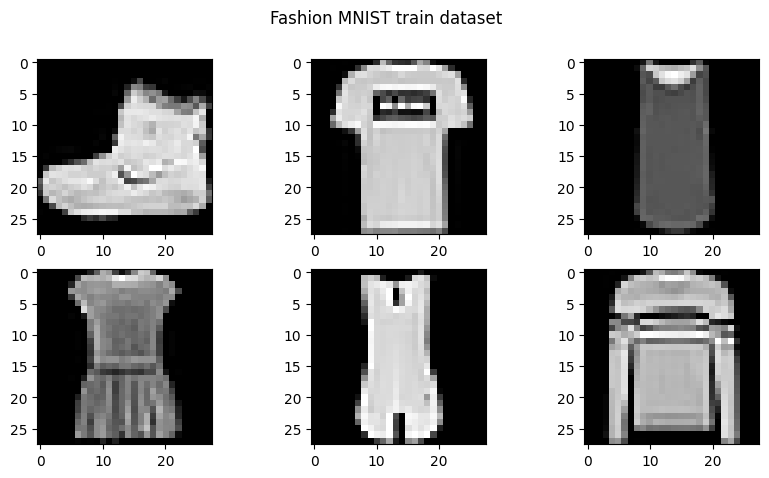

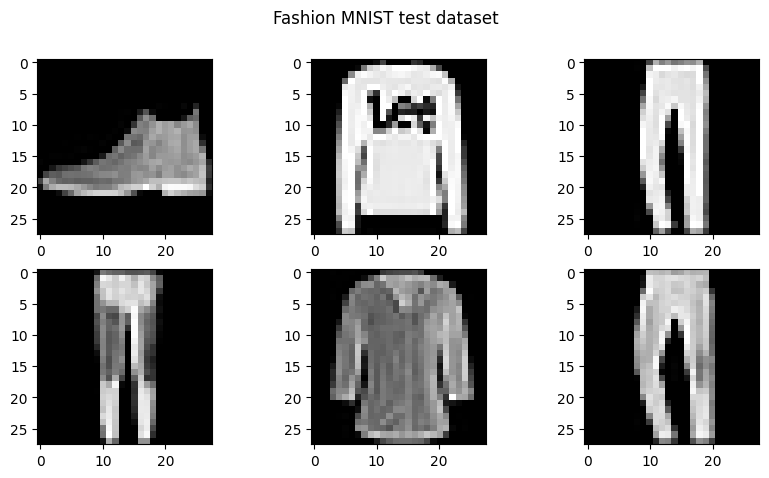

In [5]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Fashion MNIST train dataset')
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(train_loader.dataset.dataset.images[i], cmap='gray')
plt.show()

fig = plt.figure(figsize=(10, 5))
fig.suptitle('Fashion MNIST test dataset')
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(test_loader.dataset.images[i], cmap='gray')
plt.show()

## Initialising the model

In [6]:
config_model = {'task': [], 'in_channels': [], 'ConvLayers': [], 'FCLayers': [], 'pool': [], 
                'kernel_size': [], 'strides': [], 'activation': [], 'dropout': []}

config_trainer = {'model': [], 'loss': [], 'epochs': [], 'batch_size': [], 'learning_rate': [], 
                  'optimizer': [], 'wandb': False, 'labels': [], 'labelsRnum': True, 'FM_Vis': False}

## CNN Autoencoder

### Running the model

Epoch [1/10], Train Loss: 0.0042, Val Loss: 0.0021


Epoch [2/10], Train Loss: 0.0018, Val Loss: 0.0016


Epoch [3/10], Train Loss: 0.0015, Val Loss: 0.0013


Epoch [4/10], Train Loss: 0.0012, Val Loss: 0.0012


Epoch [5/10], Train Loss: 0.0011, Val Loss: 0.0010


Epoch [6/10], Train Loss: 0.0009, Val Loss: 0.0009


Epoch [7/10], Train Loss: 0.0008, Val Loss: 0.0008


Epoch [8/10], Train Loss: 0.0007, Val Loss: 0.0007


Epoch [9/10], Train Loss: 0.0007, Val Loss: 0.0007


Epoch [10/10], Train Loss: 0.0007, Val Loss: 0.0007
Testing completed.
Model saved successfully.
torch.Size([64, 1, 28, 28])


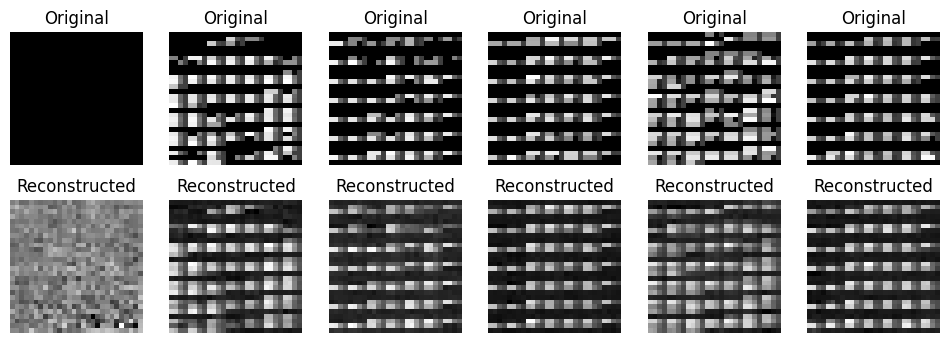

In [27]:
from tqdm import tqdm

def test_and_visualize(model, loader):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(loader))
        print(images.shape)
        # plt.imshow(images[1], cmap='gray')
        images = images.to(device)

        outputs = model(images)

        images = images.cpu().numpy()
        outputs = outputs.cpu().numpy()

        fig, axes = plt.subplots(2, 6, figsize=(12, 4))
        for i in range(6):
            axes[0, i].imshow(images[i].squeeze(), cmap='gray')
            axes[0, i].set_title("Original")
            axes[0, i].axis('off')

            axes[1, i].imshow(outputs[i].squeeze(), cmap='gray')
            axes[1, i].set_title("Reconstructed")
            axes[1, i].axis('off')
        plt.show()

batch_size = 64
data_loader = FashionMNISTLoader(batch_size=batch_size)
train_loader, val_loader, test_loader = data_loader.load_data()

config = {
    'in_channels': 1,
    'encoder_layers': [
        (16, 3, 2, 1),
        (32, 3, 2, 1),
        (64, 7, 1, 0)
    ],
    'decoder_layers': [
        (32, 7, 1, 0, 0),
        (16, 3, 2, 1, 1),
        (1, 3, 2, 1, 1)
    ],
    'lr': 0.001,
    'activation': 'relu'
}

model = cnn_autoencoder.CnnAutoencoder(config)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for images, _ in tqdm(train_loader, desc="Training", leave=False):
        images = images.to(device)

        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader.dataset)

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, _ in tqdm(val_loader, desc="Validating", leave=False):
            images = images.to(device)

            outputs = model(images)
            loss = criterion(outputs, images)

            total_loss += loss.item()

    return total_loss / len(val_loader.dataset)

def test(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)

            outputs = model(images)

    print("Testing completed.")

num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

test(model, test_loader, device)

test_and_visualize(model, test_loader)

## PCA Autoencoder

### Running code

Components: 1, Validation MSE: 0.1387
Components: 2, Validation MSE: 0.1159
Components: 3, Validation MSE: 0.1065
Components: 4, Validation MSE: 0.0994
Components: 5, Validation MSE: 0.0950
Components: 6, Validation MSE: 0.0909
Components: 7, Validation MSE: 0.0877
Components: 8, Validation MSE: 0.0847
Components: 9, Validation MSE: 0.0823
Components: 10, Validation MSE: 0.0802
Components: 11, Validation MSE: 0.0783
Components: 12, Validation MSE: 0.0766
Components: 13, Validation MSE: 0.0751
Components: 14, Validation MSE: 0.0736
Components: 15, Validation MSE: 0.0724
Components: 16, Validation MSE: 0.0712
Components: 17, Validation MSE: 0.0701
Components: 18, Validation MSE: 0.0690
Components: 19, Validation MSE: 0.0679
Components: 20, Validation MSE: 0.0669
Components: 21, Validation MSE: 0.0660
Components: 22, Validation MSE: 0.0650
Components: 23, Validation MSE: 0.0641
Components: 24, Validation MSE: 0.0633
Components: 25, Validation MSE: 0.0625
Components: 26, Validation MSE: 0.

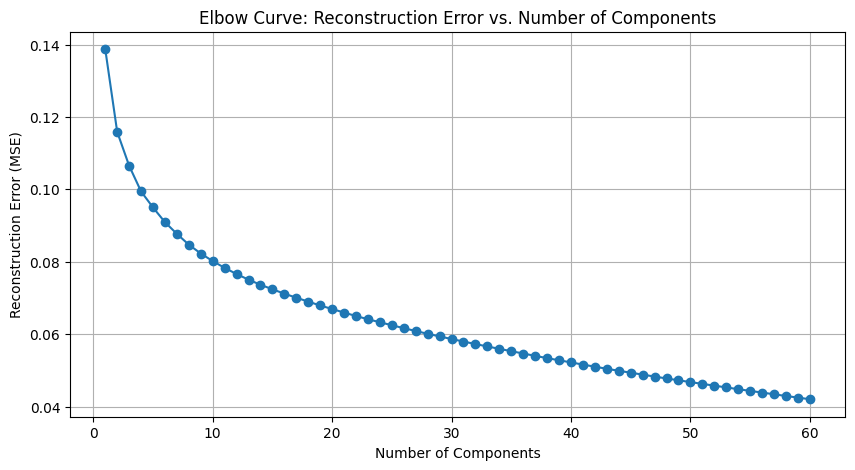

Optimal number of components: 60


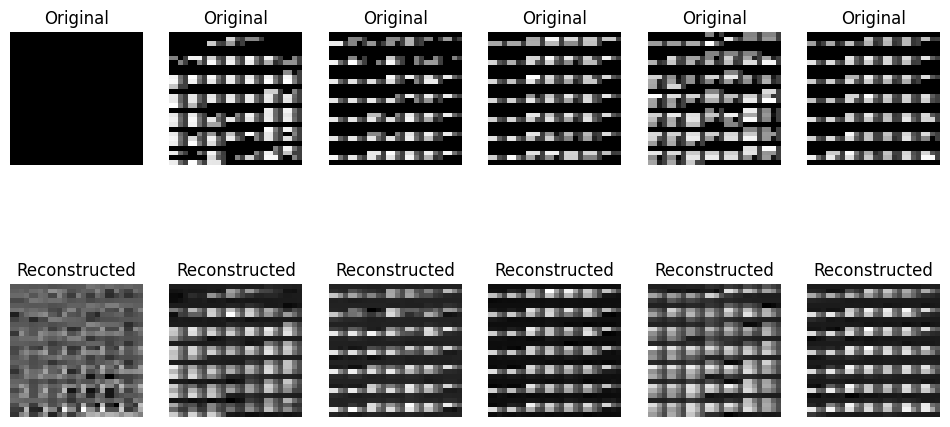

In [30]:
batch_size = 32
root = RawDataDIR
input_dim = 28 * 28
max_components = 60

data_loader = FashionMNISTLoader(batch_size=batch_size, root=root)
train_loader, val_loader, test_loader = data_loader.load_data()

pca_ae = pca_autoencoder.PcaAutoencoder(input_dim=input_dim, output_dim=max_components)

def plot_elbow_curve(errors, components):
    plt.figure(figsize=(10, 5))
    plt.plot(components, errors, marker='o')
    plt.title('Elbow Curve: Reconstruction Error vs. Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Reconstruction Error (MSE)')
    plt.grid()
    plt.show()

train_errors = []
components = list(range(1, max_components + 1))

all_train_images = []
for images, _ in train_loader:
    all_train_images.append(images.view(-1, input_dim))

all_train_images = torch.cat(all_train_images)

for k in components:
    pca_ae.output_dim = k
    pca_ae.fit(all_train_images)

    val_errors = []
    for val_images, _ in val_loader:
        val_images_flat = val_images.view(-1, input_dim)
        reconstructed = pca_ae.forward(val_images_flat)
        error = pca_ae.calculate_reconstruction_error(val_images_flat, reconstructed)
        val_errors.append(error.item())

    mean_val_error = np.mean(val_errors)
    train_errors.append(mean_val_error)
    print(f"Components: {k}, Validation MSE: {mean_val_error:.4f}")

plot_elbow_curve(train_errors, components)

optimal_components = components[np.argmin(train_errors)]
print(f"Optimal number of components: {optimal_components}")

pca_ae.eval()
test_imgs = []
for test_images, _ in test_loader:
    test_images_flat = test_images.view(-1, input_dim)
    reconstructed = pca_ae(test_images_flat).detach()

    test_imgs.append(test_images)
    test_imgs.append(reconstructed.view(-1, 1, 28, 28))

def plot_images(original, reconstructed, n=6):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title('Original')

        plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructed[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed')
    plt.show()

original_images = test_imgs[0][:6]
reconstructed_images = test_imgs[1][:6]
plot_images(original_images, reconstructed_images)


From the Elbow plot, it is difficult to concretely conclude about the right number of components because the graph is quite smooth. However, we can see that there is some change in slope of the curve between points 7 and 10 on the x-axis. Therefore, I find it appropriate to take the optimal number of components as 7.

## MLP Autoencoder

### Running Code

In [33]:
config = {'learning_rate': [], 'epochs': [], 'batch_size': [], 'optimizer': [], 'grad_verify': False, 
                       'loss': [], 'layers': [], 'activations': [], 'type': model, 'wb': False}
config['learning_rate'] = 0.01
config['epochs'] = 1
config['activations'] = 'relu'
config['batch_size'] = 256
config['layers'] = [256, 64, 256, 784]
config['loss'] = 'mse'
config['optimizer'] = 'sgd'
mlp_ae = auto_encoder.AutoEncoder(config)

X_train = []
for images, _ in train_loader:
    image = images.view(images.size(0), -1)
    for i in image:
        i = i.numpy()
        X_train.append(i)

X_train = np.array(X_train)

X_val = []
for images, _ in val_loader:
    image = images.view(images.size(0), -1)
    for i in image:
        i = i.numpy()
        X_val.append(i)

X_val = np.array(X_val)

X_test = []
for images, _ in test_loader:
    image = images.view(images.size(0), -1)
    for i in image:
        i = i.numpy()
        X_test.append(i)

X_test = np.array(X_test)

mlp_ae.fit(X_train, X_train, X_val, X_val)
print(mlp_ae.evaluate(X_test, X_test))

Epoch:  0
{'loss': 0.13536964743365082, 'mse': 0.13536964743365082, 'rmse': 0.36792614399312645, 'r2': 0.618306320307757}


## Hyperparameter Tuning for CNN_Autoencoder

encoder_layers = [16, 11]\
latent_layer = 7\
decoder_layers = [11, 16]\
lr = 0.001\
kernel_size = [3, 3, 7]
optimiser = adam

Epoch [1/10], Train Loss: 0.0049, Val Loss: 0.0037


Epoch [2/10], Train Loss: 0.0028, Val Loss: 0.0022


Epoch [3/10], Train Loss: 0.0020, Val Loss: 0.0018


Epoch [4/10], Train Loss: 0.0017, Val Loss: 0.0017


Epoch [5/10], Train Loss: 0.0016, Val Loss: 0.0016


Epoch [6/10], Train Loss: 0.0015, Val Loss: 0.0015


Epoch [7/10], Train Loss: 0.0015, Val Loss: 0.0015


Epoch [8/10], Train Loss: 0.0014, Val Loss: 0.0014


Epoch [9/10], Train Loss: 0.0014, Val Loss: 0.0014


Epoch [10/10], Train Loss: 0.0014, Val Loss: 0.0014
Testing completed.


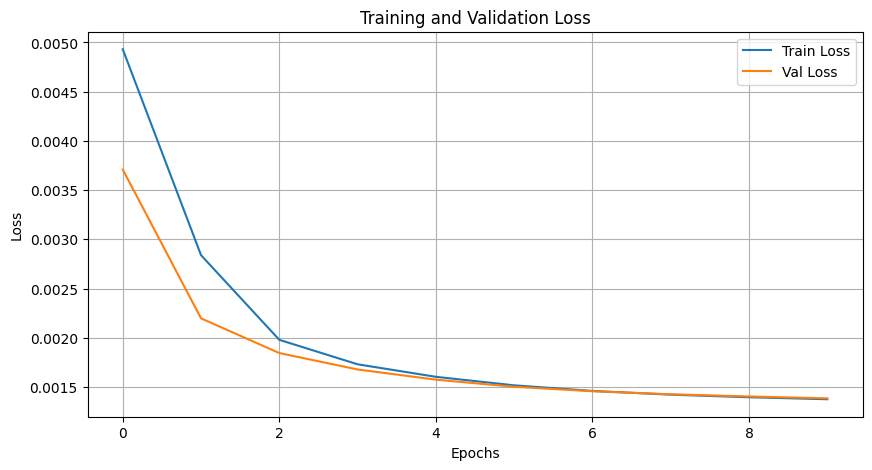

In [35]:
from tqdm import tqdm

def test_and_visualize(model, loader):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(loader))
        print(images.shape)
        # plt.imshow(images[1], cmap='gray')
        images = images.to(device)

        outputs = model(images)

        images = images.cpu().numpy()
        outputs = outputs.cpu().numpy()

        fig, axes = plt.subplots(2, 6, figsize=(12, 4))
        for i in range(6):
            axes[0, i].imshow(images[i].squeeze(), cmap='gray')
            axes[0, i].set_title("Original")
            axes[0, i].axis('off')

            axes[1, i].imshow(outputs[i].squeeze(), cmap='gray')
            axes[1, i].set_title("Reconstructed")
            axes[1, i].axis('off')
        plt.show()

batch_size = 64
data_loader = FashionMNISTLoader(batch_size=batch_size)
train_loader, val_loader, test_loader = data_loader.load_data()

config = {
    'in_channels': 1,
    'encoder_layers': [
        (16, 3, 2, 1),
        (11, 3, 2, 1),
        (7, 7, 1, 0)
    ],
    'decoder_layers': [
        (11, 7, 1, 0, 0),
        (16, 3, 2, 1, 1),
        (1, 3, 2, 1, 1)
    ],
    'lr': 0.001,
    'activation': 'relu'
}

model = cnn_autoencoder.CnnAutoencoder(config)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for images, _ in tqdm(train_loader, desc="Training", leave=False):
        images = images.to(device)

        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader.dataset)

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, _ in tqdm(val_loader, desc="Validating", leave=False):
            images = images.to(device)

            outputs = model(images)
            loss = criterion(outputs, images)

            total_loss += loss.item()

    return total_loss / len(val_loader.dataset)

def test(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)

            outputs = model(images)

    print("Testing completed.")

num_epochs = 10
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_losses.append(train(model, train_loader, criterion, optimizer, device))
    val_losses.append(validate(model, val_loader, criterion, device))

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

test(model, test_loader, device)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

encoder_layers = [16, 12, 9]\
latent_layer = 7\
decoder_layers = [9, 12, 16]\
lr = 0.001\
kernel_size = [5, 3, 3, 7]\
optimiser = adam

Epoch [1/10], Train Loss: 0.0047, Val Loss: 0.0032


Epoch [2/10], Train Loss: 0.0027, Val Loss: 0.0023


Epoch [3/10], Train Loss: 0.0021, Val Loss: 0.0019


Epoch [4/10], Train Loss: 0.0018, Val Loss: 0.0017


Epoch [5/10], Train Loss: 0.0016, Val Loss: 0.0015


Epoch [6/10], Train Loss: 0.0015, Val Loss: 0.0015


Epoch [7/10], Train Loss: 0.0015, Val Loss: 0.0014


Epoch [8/10], Train Loss: 0.0014, Val Loss: 0.0014


Epoch [9/10], Train Loss: 0.0014, Val Loss: 0.0014


Epoch [10/10], Train Loss: 0.0014, Val Loss: 0.0014
Testing completed.


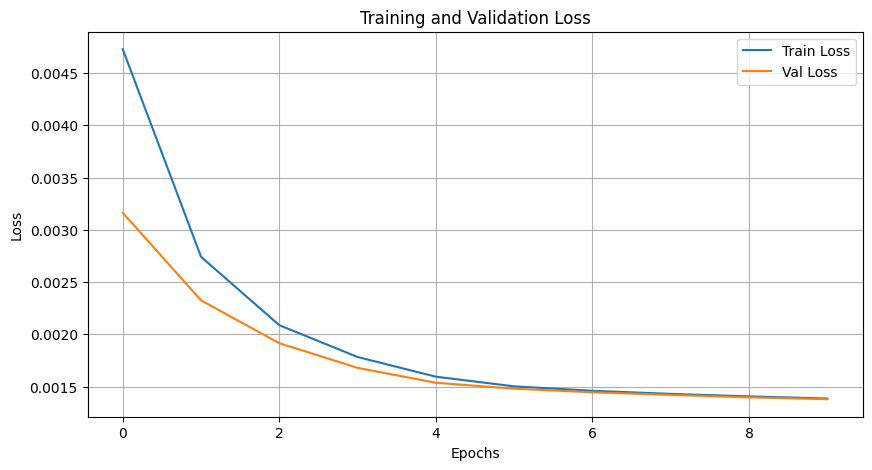

In [50]:
def test_and_visualize(model, loader):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(loader))
        print(images.shape)

        images = images.to(device)

        outputs = model(images)

        images = images.cpu().numpy()
        outputs = outputs.cpu().numpy()

        fig, axes = plt.subplots(2, 6, figsize=(12, 4))
        for i in range(6):
            axes[0, i].imshow(images[i].squeeze(), cmap='gray')
            axes[0, i].set_title("Original")
            axes[0, i].axis('off')

            axes[1, i].imshow(outputs[i].squeeze(), cmap='gray')
            axes[1, i].set_title("Reconstructed")
            axes[1, i].axis('off')
        plt.show()

batch_size = 64
data_loader = FashionMNISTLoader(batch_size=batch_size)
train_loader, val_loader, test_loader = data_loader.load_data()

config = {
    'in_channels': 1,
    'encoder_layers': [
        (16, 5, 1, 2),
        (12, 3, 2, 1),
        (9, 3, 2, 1),
        (7, 7, 1, 0)
    ],
    'decoder_layers': [
        (9, 7, 1, 0, 0),
        (12, 3, 2, 1, 1),
        (16, 3, 2, 1, 1),
        (1, 5, 1, 2, 0)
    ],
    'lr': 0.001,
    'activation': 'relu'
}

model = cnn_autoencoder.CnnAutoencoder(config)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for images, _ in tqdm(train_loader, desc="Training", leave=False):
        images = images.to(device)

        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader.dataset)

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, _ in tqdm(val_loader, desc="Validating", leave=False):
            images = images.to(device)

            outputs = model(images)
            loss = criterion(outputs, images)

            total_loss += loss.item()

    return total_loss / len(val_loader.dataset)

def test(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)

            outputs = model(images)

    print("Testing completed.")

num_epochs = 10
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_losses.append(train(model, train_loader, criterion, optimizer, device))
    val_losses.append(validate(model, val_loader, criterion, device))

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

test(model, test_loader, device)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

encoder_layers = [16, 11]\
latent_layer = 7\
decoder_layers = [11, 16]\
lr = 0.001\
kernel_size = [3, 3, 7]\
optimiser = sgd

Epoch [1/10], Train Loss: 0.0162, Val Loss: 0.0144


Epoch [2/10], Train Loss: 0.0129, Val Loss: 0.0117


Epoch [3/10], Train Loss: 0.0107, Val Loss: 0.0098


Epoch [4/10], Train Loss: 0.0092, Val Loss: 0.0086


Epoch [5/10], Train Loss: 0.0081, Val Loss: 0.0077


Epoch [6/10], Train Loss: 0.0074, Val Loss: 0.0071


Epoch [7/10], Train Loss: 0.0068, Val Loss: 0.0067


Epoch [8/10], Train Loss: 0.0065, Val Loss: 0.0064


Epoch [9/10], Train Loss: 0.0062, Val Loss: 0.0061


Epoch [10/10], Train Loss: 0.0060, Val Loss: 0.0060
Testing completed.


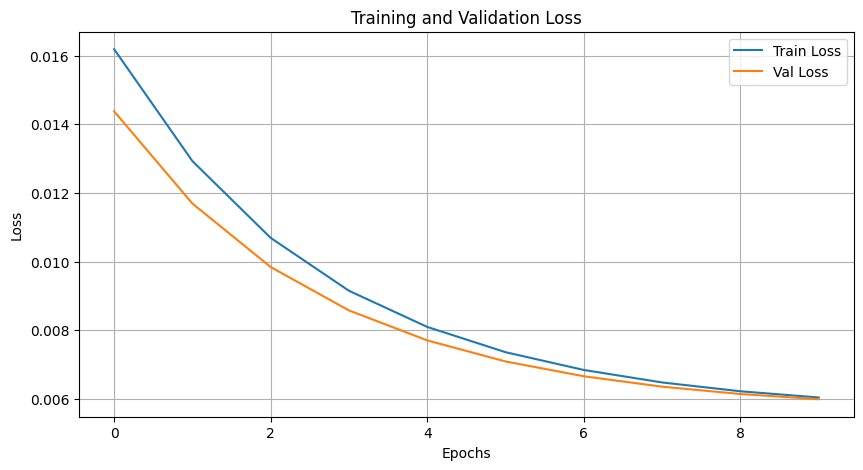

In [51]:
def test_and_visualize(model, loader):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(loader))
        print(images.shape)
        # plt.imshow(images[1], cmap='gray')
        images = images.to(device)

        outputs = model(images)

        images = images.cpu().numpy()
        outputs = outputs.cpu().numpy()

        fig, axes = plt.subplots(2, 6, figsize=(12, 4))
        for i in range(6):
            axes[0, i].imshow(images[i].squeeze(), cmap='gray')
            axes[0, i].set_title("Original")
            axes[0, i].axis('off')

            axes[1, i].imshow(outputs[i].squeeze(), cmap='gray')
            axes[1, i].set_title("Reconstructed")
            axes[1, i].axis('off')
        plt.show()

batch_size = 64
data_loader = FashionMNISTLoader(batch_size=batch_size)
train_loader, val_loader, test_loader = data_loader.load_data()

config = {
    'in_channels': 1,
    'encoder_layers': [
        (16, 3, 2, 1),
        (11, 3, 2, 1),
        (7, 7, 1, 0)
    ],
    'decoder_layers': [
        (11, 7, 1, 0, 0),
        (16, 3, 2, 1, 1),
        (1, 3, 2, 1, 1)
    ],
    'lr': 0.001,
    'activation': 'relu'
}

model = cnn_autoencoder.CnnAutoencoder(config)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for images, _ in tqdm(train_loader, desc="Training", leave=False):
        images = images.to(device)

        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader.dataset)

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, _ in tqdm(val_loader, desc="Validating", leave=False):
            images = images.to(device)

            outputs = model(images)
            loss = criterion(outputs, images)

            total_loss += loss.item()

    return total_loss / len(val_loader.dataset)

def test(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)

            outputs = model(images)

    print("Testing completed.")

num_epochs = 10
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_losses.append(train(model, train_loader, criterion, optimizer, device))
    val_losses.append(validate(model, val_loader, criterion, device))

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

test(model, test_loader, device)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

encoder_layers = [16, 11]\
latent_layer = 7\
decoder_layers = [11, 16]\
lr = 0.01\
kernel_size = [5, 5, 7]\
optimiser = sgd

Epoch [1/10], Train Loss: 0.0055, Val Loss: 0.0047


Epoch [2/10], Train Loss: 0.0044, Val Loss: 0.0042


Epoch [3/10], Train Loss: 0.0041, Val Loss: 0.0041


Epoch [4/10], Train Loss: 0.0041, Val Loss: 0.0041


Epoch [5/10], Train Loss: 0.0041, Val Loss: 0.0041


Epoch [6/10], Train Loss: 0.0040, Val Loss: 0.0040


Epoch [7/10], Train Loss: 0.0040, Val Loss: 0.0040


Epoch [8/10], Train Loss: 0.0040, Val Loss: 0.0040


Epoch [9/10], Train Loss: 0.0039, Val Loss: 0.0040


Epoch [10/10], Train Loss: 0.0039, Val Loss: 0.0039
Testing completed.


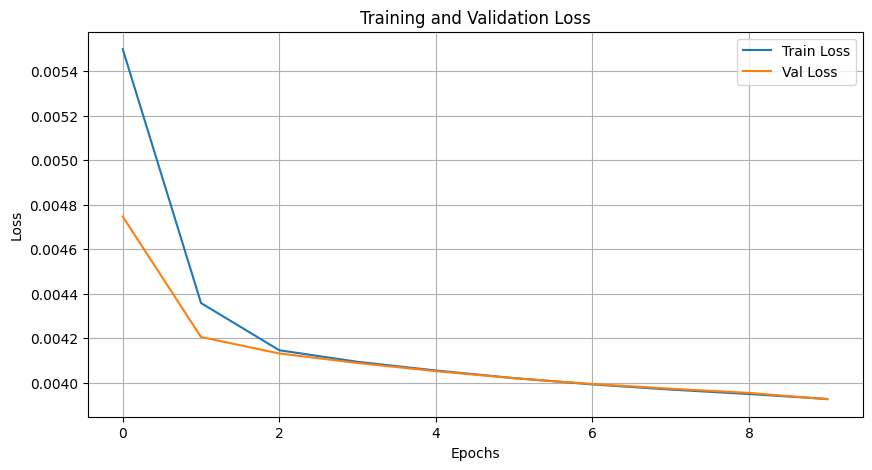

In [52]:
def test_and_visualize(model, loader):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(loader))
        print(images.shape)
        # plt.imshow(images[1], cmap='gray')
        images = images.to(device)

        outputs = model(images)

        images = images.cpu().numpy()
        outputs = outputs.cpu().numpy()

        fig, axes = plt.subplots(2, 6, figsize=(12, 4))
        for i in range(6):
            axes[0, i].imshow(images[i].squeeze(), cmap='gray')
            axes[0, i].set_title("Original")
            axes[0, i].axis('off')

            axes[1, i].imshow(outputs[i].squeeze(), cmap='gray')
            axes[1, i].set_title("Reconstructed")
            axes[1, i].axis('off')
        plt.show()

batch_size = 64
data_loader = FashionMNISTLoader(batch_size=batch_size)
train_loader, val_loader, test_loader = data_loader.load_data()

config = {
    'in_channels': 1,
    'encoder_layers': [
        (16, 5, 2, 2),
        (11, 5, 2, 2),
        (7, 7, 1, 0)
    ],
    'decoder_layers': [
        (11, 7, 1, 0, 0),
        (16, 5, 2, 2, 1),
        (1, 5, 2, 2, 1)
    ],
    'lr': 0.001,
    'activation': 'relu'
}

model = cnn_autoencoder.CnnAutoencoder(config)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for images, _ in tqdm(train_loader, desc="Training", leave=False):
        images = images.to(device)

        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader.dataset)

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, _ in tqdm(val_loader, desc="Validating", leave=False):
            images = images.to(device)

            outputs = model(images)
            loss = criterion(outputs, images)

            total_loss += loss.item()

    return total_loss / len(val_loader.dataset)

def test(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)

            outputs = model(images)

    print("Testing completed.")

num_epochs = 10
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_losses.append(train(model, train_loader, criterion, optimizer, device))
    val_losses.append(validate(model, val_loader, criterion, device))

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

test(model, test_loader, device)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Observations:\
From the above plots, it can be concluded that the very first model with following config:
1. encoder_layers = [16, 11]
2. latent_layer = 7
3. decoder_layers = [11, 16]
4. lr = 0.001
5. kernel_size = [3, 3, 7]
6. optimiser = adam
does fairly good. 

Even the second model where the number of layers are increased does similar but that takes time. 

NOTE: I have kept the number of latent features constant and have played around with the other hyperparameters.

## KNN 

In [53]:
train_labels = []
for _,label in train_loader:
    train_labels.append(label)
train_labels = torch.cat(train_labels)
train_labels = train_labels.numpy()

val_labels = []
for _,label in val_loader:
    val_labels.append(label)
val_labels = torch.cat(val_labels)
val_labels = val_labels.numpy()

test_labels = []
for _,label in test_loader:
    test_labels.append(label)
test_labels = torch.cat(test_labels)
test_labels = test_labels.numpy()

### Reducing features

#### Using PCA Autoencoder

In [55]:
input_dim = 28*28

all_train_images = []
for images, _ in train_loader:
    all_train_images.append(images.view(-1, input_dim))

all_train_images = torch.cat(all_train_images)

all_val_images = []
for images, _ in val_loader:
    all_val_images.append(images.view(-1, input_dim))

all_val_images = torch.cat(all_val_images)

all_test_images = []
for images, _ in test_loader:
    all_test_images.append(images.view(-1, input_dim))

all_test_images = torch.cat(all_test_images)

pca_ae = pca_autoencoder.PcaAutoencoder(28*28, 7)
pca_ae.fit(all_train_images)

X_train_pca = []
for i in all_train_images:
    i = i.reshape((1, -1))
    out = pca_ae.encode(i)
    X_train_pca.append(out.numpy().reshape(-1))
X_train_pca = np.array(X_train_pca)
print(X_train_pca.shape)

X_val_pca = []
for i in all_val_images:
    i = i.reshape((1, -1))
    out = pca_ae.encode(i)
    X_val_pca.append(out.numpy().reshape(-1))
X_val_pca = np.array(X_val_pca)
print(X_val_pca.shape)

X_test_pca = []
for i in all_test_images:
    i = i.reshape((1, -1))
    out = pca_ae.encode(i)
    X_test_pca.append(out.numpy().reshape(-1))
X_test_pca = np.array(X_test_pca)
print(X_test_pca.shape)

(48000, 7)
(12000, 7)
(10000, 7)


#### Using CNN Autoencoder

In [58]:
X = []
config = {
    'in_channels': 1,
    'encoder_layers': [
        (16, 3, 2, 1),
        (11, 3, 2, 1),
        (7, 7, 1, 0)
    ],
    'decoder_layers': [
        (11, 7, 1, 0, 0),
        (16, 3, 2, 1, 1),
        (1, 3, 2, 1, 1)
    ],
    'lr': 0.001,
    'activation': 'relu'
}
model = cnn_autoencoder.CnnAutoencoder(config)

for images, _ in train_loader:
    X.append(images)
X = torch.cat(X)
X_train_cnn = []
for image in X:
    X_train_cnn.append(model.encode(image).detach().numpy().reshape(-1))
X_train_cnn = np.array(X_train_cnn)
print(X_train_cnn.shape)

X = []
for images, _ in val_loader:
    X.append(images)
X = torch.cat(X)
X_val_cnn = []
for image in X:
    X_val_cnn.append(model.encode(image).detach().numpy().reshape(-1))
X_val_cnn = np.array(X_val_cnn)
print(X_val_cnn.shape)

X = []
for images, _ in test_loader:
    X.append(images)
X = torch.cat(X)
X_test_cnn = []
for image in X:
    X_test_cnn.append(model.encode(image).detach().numpy().reshape(-1))
X_test_cnn = np.array(X_test_cnn)
print(X_test_cnn.shape)

(48000, 7)
(12000, 7)
(10000, 7)


#### MLP Autoencoder

In [60]:
config = {'learning_rate': [], 'epochs': [], 'batch_size': [], 'optimizer': [], 'grad_verify': False, 
                       'loss': [], 'layers': [], 'activations': [], 'type': model, 'wb': False}
config['learning_rate'] = 0.01
config['epochs'] = 5
config['activations'] = 'relu'
config['batch_size'] = 256
config['layers'] = [128, 7, 128, 784]
config['loss'] = 'mse'
config['optimizer'] = 'sgd'
mlp_ae = auto_encoder.AutoEncoder(config)

X_train = []
for images, _ in train_loader:
    image = images.view(images.size(0), -1)
    for i in image:
        i = i.numpy()
        X_train.append(i)

X_train = np.array(X_train)

X_val = []
for images, _ in val_loader:
    image = images.view(images.size(0), -1)
    for i in image:
        i = i.numpy()
        X_val.append(i)

X_val = np.array(X_val)

X_test = []
for images, _ in test_loader:
    image = images.view(images.size(0), -1)
    for i in image:
        i = i.numpy()
        X_test.append(i)

X_test = np.array(X_test)

mlp_ae.fit(X_train, X_train, X_val, X_val)
print(mlp_ae.evaluate(X_test, X_test))

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
{'loss': 0.09284734512377595, 'mse': 0.09284734512377595, 'rmse': 0.30470862331705667, 'r2': 0.7382039069923734}


In [61]:
X_train_mlp = mlp_ae.get_latent(X_train)
X_val_mlp = mlp_ae.get_latent(X_val)
X_test_mlp = mlp_ae.get_latent(X_test)

print(X_train_mlp.shape, X_val_mlp.shape, X_test_mlp.shape)

(48000, 7) (12000, 7) (10000, 7)


### Running the model

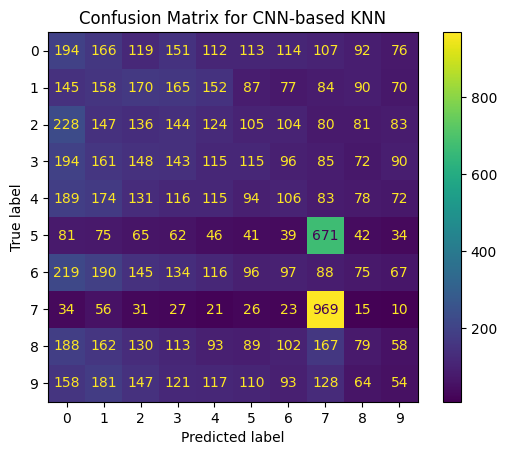

Accuracy: 16.55
Precision: (0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 0.1655, 0.1330284882673932, 

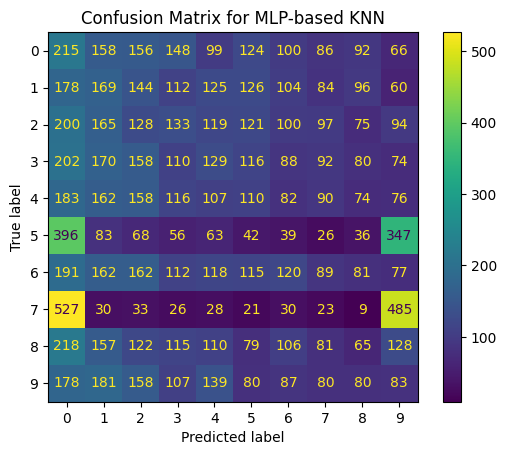

Accuracy: 8.85
Precision: (0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156635, 0.0885, 0.08790243653156

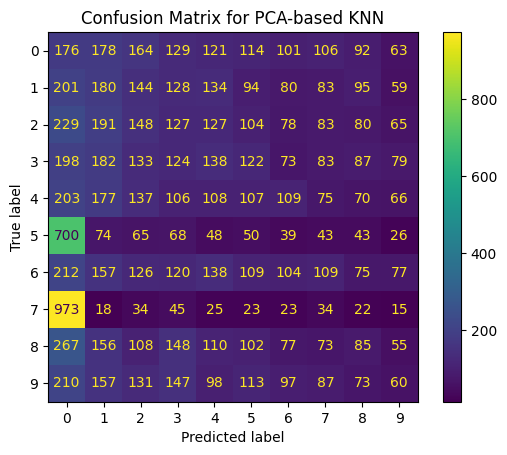

Accuracy: 8.908333333333333
Precision: (0.09649982183048975, 0.08908333333333333, 0.09649982183048975, 0.08908333333333333, 0.09649982183048975, 0.08908333333333333, 0.09649982183048975, 0.08908333333333333, 0.09649982183048975, 0.08908333333333333, 0.09649982183048975, 0.08908333333333333, 0.09649982183048975, 0.08908333333333333, 0.09649982183048975, 0.08908333333333333, 0.09649982183048975, 0.08908333333333333, 0.09649982183048975, 0.08908333333333333, 0.09649982183048975, 0.08908333333333333, 0.09649982183048975, 0.08908333333333333, 0.09649982183048975, 0.08908333333333333, 0.09649982183048975, 0.08908333333333333, 0.09649982183048975, 0.08908333333333333, 0.09649982183048975, 0.08908333333333333, 0.09649982183048975, 0.08908333333333333, 0.09649982183048975, 0.08908333333333333, 0.09649982183048975, 0.08908333333333333, 0.09649982183048975, 0.08908333333333333, 0.09649982183048975, 0.08908333333333333, 0.09649982183048975, 0.08908333333333333, 0.09649982183048975, 0.0890833333333

In [64]:
from models.knn.knn import *
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X_train_cnn = pd.DataFrame(X_train_cnn)
X_val_cnn = pd.DataFrame(X_val_cnn)
X_test_cnn = pd.DataFrame(X_test_cnn)

X_train_pca = pd.DataFrame(X_train_pca)
X_val_pca = pd.DataFrame(X_val_pca)
X_test_pca = pd.DataFrame(X_test_pca)

X_train_mlp = pd.DataFrame(X_train_mlp)
X_val_mlp = pd.DataFrame(X_val_mlp)
X_test_mlp = pd.DataFrame(X_test_mlp)

train_labels = pd.DataFrame(train_labels)
val_labels = pd.DataFrame(val_labels)
test_labels = pd.DataFrame(test_labels)

def fit_predict_confusion(X_train, X_val, train_labels, val_labels, title):
    knn = KNN()
    knn.fit(X_train, train_labels)
    knn.SetNumNeighbors(15)
    knn.SetDistMetric('l1')
    knn.FindDistances(X_val, 'optimised')
    y_pred, acc, prec, recall, f1 = knn.predict(X_val, val_labels)

    cm = confusion_matrix(val_labels, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(title)
    plt.show()
    
    print(f"Accuracy: {acc}")
    print(f"Precision: {prec}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

fit_predict_confusion(X_train_cnn, X_test_cnn, train_labels, test_labels, "Confusion Matrix for CNN-based KNN")
fit_predict_confusion(X_train_mlp, X_test_mlp, train_labels, test_labels, "Confusion Matrix for MLP-based KNN")
fit_predict_confusion(X_train_pca, X_test_pca, train_labels, test_labels, "Confusion Matrix for PCA-based KNN")

Observations:\
As expected, the MLP-based KNN classification produced worst of all three accuracies. This was also evident from the loss graphs earlier. This was followed by PCA-based KNN classification which yields a little better performance. The best performance was given by CNN-based KNN classification with a whooping 16% accuracy. \
All the three performances are also evident from the confusion matrices plotted above. The CNN-based results seemed to be the most in line with the true labels as compared to those produced as a result of other two methods.